In [48]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import muon as mu
from muon import prot as pt
import os
import h5py
from mudata import MuData
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_array
import anndata as ad

In [2]:
sc.set_figure_params(frameon=False, figsize=(4, 4))


In [49]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [50]:
from sklearn.mixture import GaussianMixture  # different in updated sklearn (prev GMM)
from sklearn.metrics import confusion_matrix
from matplotlib.colors import rgb2hex

In [10]:
file_dir = '/Users/anasuyadighe/Downloads/'
samples = ['P1-TD-d8', 'P2-T1-d8', 'P3-TD-d12', 'P4-T2-d12', 'P5-T0-d15', 'P6-T4-d15']
paths = [file_dir + n + '/' for n in samples]


In [11]:
paths

['/Users/anasuyadighe/Downloads/P1-TD-d8/',
 '/Users/anasuyadighe/Downloads/P2-T1-d8/',
 '/Users/anasuyadighe/Downloads/P3-TD-d12/',
 '/Users/anasuyadighe/Downloads/P4-T2-d12/',
 '/Users/anasuyadighe/Downloads/P5-T0-d15/',
 '/Users/anasuyadighe/Downloads/P6-T4-d15/']

In [12]:
mdatas_rna = []
mdatas_prot = []
mdatas_raw_rna = []
mdatas_raw_prot = []

In [13]:
isotype_controls = ['IgG2b_control_TotalSeqB', 'IgG1_control_TotalSeqB', 'IgG2a_control_TotalSeqB']

In [14]:
for path1, sample in zip(paths, samples):
    # reading in filtered data
    adatas = mu.read_10x_h5(os.path.join(path1, "sample_filtered_feature_bc_matrix.h5"))
    adatas.var_names_make_unique()

    adatas_raw = mu.read_10x_h5(os.path.join(path1, "raw_feature_bc_matrix.h5"))
    adatas_raw.var_names_make_unique()

    # complete per sample protein normalization
    # hanging on to non-norm data
    adatas.mod['prot'].layers["counts"] = adatas.mod['prot'].X

    # do the norm
    mu.prot.pp.dsb(adatas.mod['prot'], adatas_raw.mod['prot'], isotype_controls=isotype_controls)

    mdatas_rna.append(adatas.mod['rna'])
    mdatas_prot.append(adatas.mod['prot'])

    mdatas_raw_rna.append(adatas_raw.mod['rna'])
    mdatas_raw_prot.append(adatas_raw.mod['prot'])


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/muon/_prot/preproc.py:109: UserWarning: empty_counts_range values are not provided, treating all the non-cells as empty droplets
  warn(


In [15]:
mdata_rna = mdatas_rna[0].concatenate(mdatas_rna[1:], batch_key='sample', batch_categories=samples)
mdata_prot = mdatas_prot[0].concatenate(mdatas_prot[1:], batch_key='sample', batch_categories=samples)

mdata_raw_rna = mdatas_raw_rna[0].concatenate(mdatas_raw_rna[1:], batch_key='sample', batch_categories=samples)
mdata_raw_prot = mdatas_raw_prot[0].concatenate(mdatas_raw_prot[1:], batch_key='sample', batch_categories=samples)

mdata = MuData({"rna": mdata_rna, "prot": mdata_prot})
mdata_raw = MuData({"rna": mdata_raw_rna, "prot": mdata_raw_prot})

del mdatas_rna, mdatas_prot, mdatas_raw_rna, mdatas_raw_prot

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


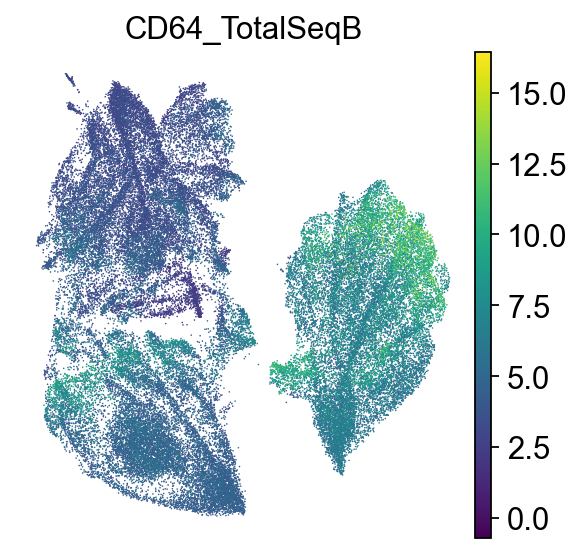

In [16]:
prot = mdata.mod['prot']
sc.tl.pca(prot)
sc.pp.neighbors(prot)
sc.tl.umap(prot)
sc.pl.umap(prot, color='CD64_TotalSeqB')


In [17]:
rna = mdata.mod['rna']


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


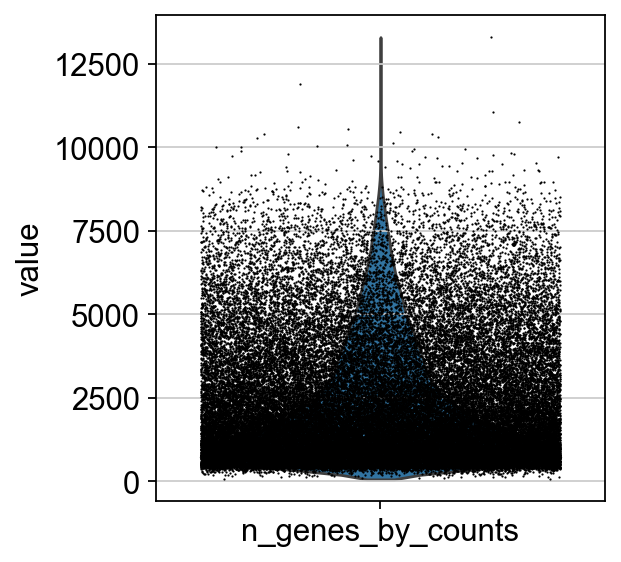

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


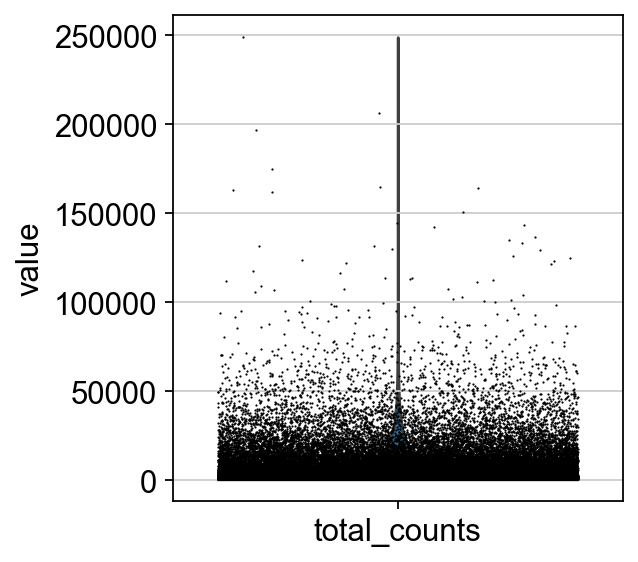

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


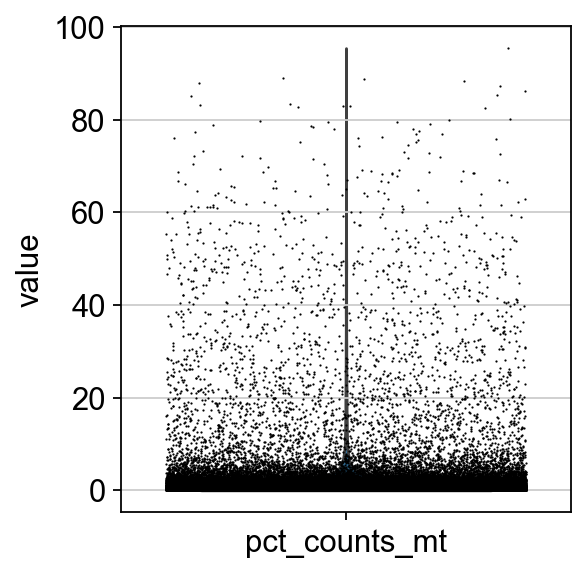

In [20]:
rna.var['mt'] = rna.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(rna, keys  = 'n_genes_by_counts', jitter=0.4, multi_panel=False )
sc.pl.violin(rna, keys  = 'total_counts', jitter=0.4, multi_panel=False )
sc.pl.violin(rna, keys  = 'pct_counts_mt', jitter=0.4, multi_panel=False )

In [21]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: x >= 200)
mu.pp.filter_obs(rna, 'total_counts', lambda x: x > 500)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 7.5)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


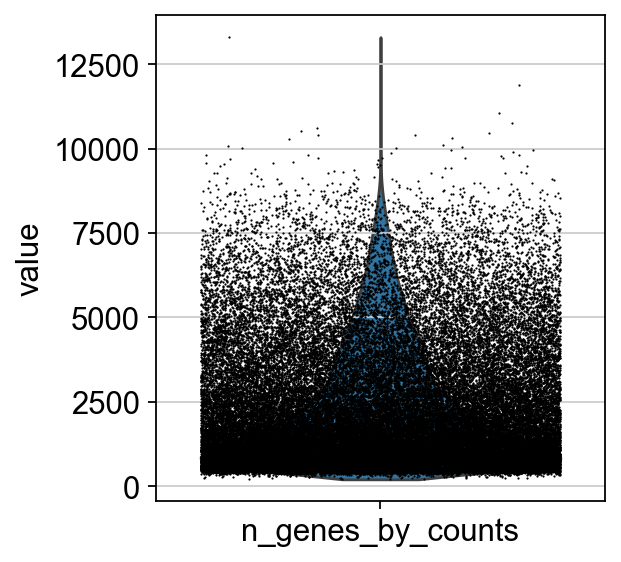

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


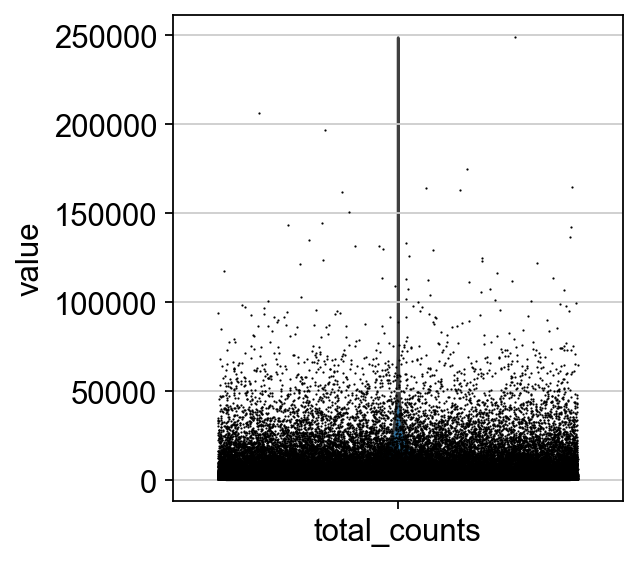

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


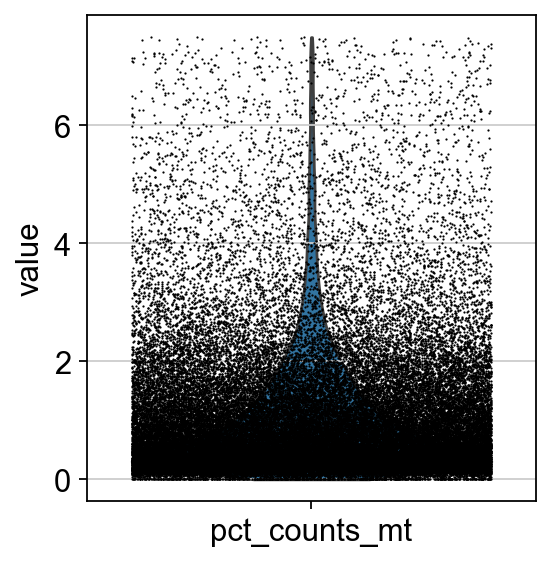

In [22]:
sc.pl.violin(rna, keys  = 'n_genes_by_counts', jitter=0.4, multi_panel=False )
sc.pl.violin(rna, keys  = 'total_counts', jitter=0.4, multi_panel=False )
sc.pl.violin(rna, keys  = 'pct_counts_mt', jitter=0.4, multi_panel=False )

In [23]:
sc.pp.normalize_per_cell(rna, counts_per_cell_after=1e6)
sc.pp.log1p(rna)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


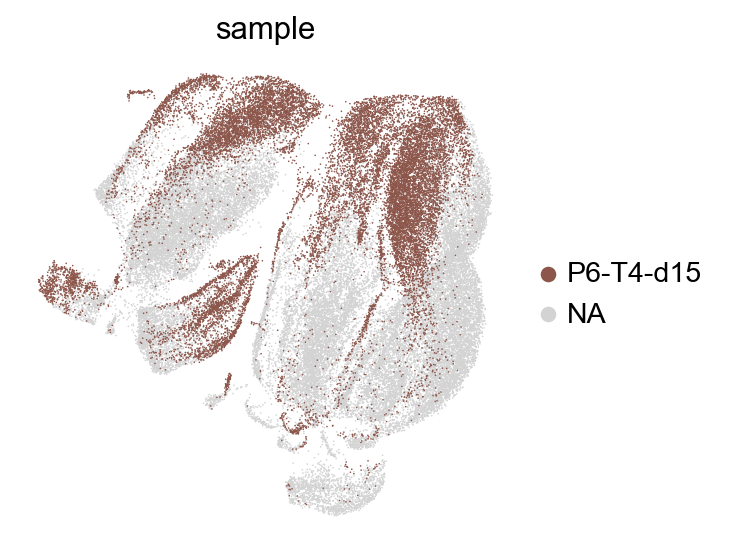

In [24]:
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=15, n_pcs=50)
sc.tl.umap(rna)
sc.pl.umap(rna, color='sample', groups=['P6-T4-d15'])

In [25]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag3_TotalSeqB','Hashtag4_TotalSeqB', 'Hashtag5_TotalSeqB', 'Hashtag6_TotalSeqB'])

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


In [26]:
hash_data = prot[:, :6].copy().to_df()
hash_data['sample'] = prot.obs['sample']


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


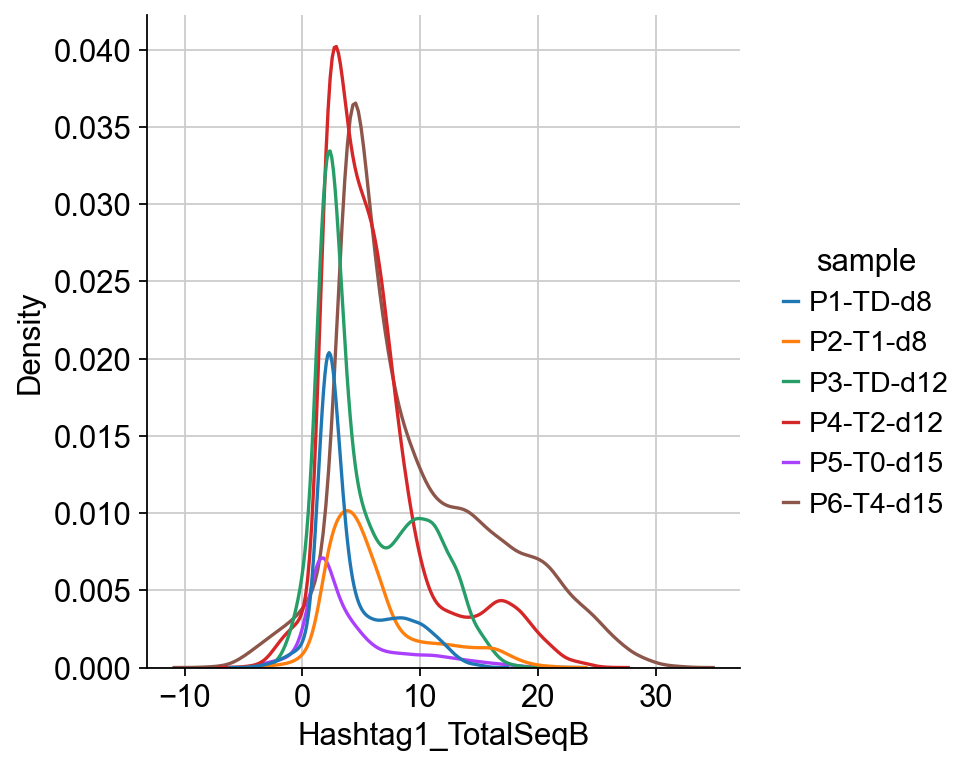

In [28]:
sc.tl.leiden(rna)
hash_data = hash_data.loc[rna.obs_names.values]
hash_data['leiden'] = rna.obs['leiden']
# updating to include leiden clustering (to distinguish CD45 +/-)
sns.displot(data=hash_data, x="Hashtag1_TotalSeqB", hue="sample", kind="kde")

In [29]:
hash_onoff = np.zeros((hash_data.shape[0], hash_data.shape[1]-2))
hash_dict = {'P1-TD-d8': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag3_TotalSeqB', 'Hashtag4_TotalSeqB', 'Hashtag5_TotalSeqB', 'Hashtag6_TotalSeqB'],
             'P2-T1-d8': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag3_TotalSeqB', 'Hashtag4_TotalSeqB', 'Hashtag5_TotalSeqB', 'Hashtag6_TotalSeqB'],
             'P3-TD-d12': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag3_TotalSeqB', 'Hashtag4_TotalSeqB'],
             'P4-T2-d12': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag5_TotalSeqB', 'Hashtag6_TotalSeqB'],
             'P5-T0-d15': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag5_TotalSeqB', 'Hashtag6_TotalSeqB'],
             'P6-T4-d15': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag3_TotalSeqB', 'Hashtag4_TotalSeqB']}

In [31]:
adata = mu.read('/Users/anasuyadighe/Downloads/20230616_GAP-hashed-persamplenorm-iter2.h5mu')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [34]:
rna = adata.mod['rna']

In [35]:
prot = adata.mod['prot']

In [36]:
rna_sing = rna[rna.obs['hashing'].str.contains('1.0')]
prot_sing = prot[rna_sing.obs_names]

In [37]:
hashtag_dict = {0: 'Hash 1',
                1: 'Hash 2',
                2: 'Hash 3',
                3: 'Hash 4',
                4: 'Hash 5',
                5: 'Hash 6'}

rna_sing.obs['hashtag'] = np.argmax(hash_onoff[np.where(rna.obs['hashing'].str.contains('1.0'))], axis=1)
rna_sing.obs['hashtag'] = rna_sing.obs['hashtag'].map(hashtag_dict)
prot_sing.obs['hashtag'] = rna_sing.obs['hashtag']

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_54206/3618626230.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_sing.obs['hashtag'] = np.argmax(hash_onoff[np.where(rna.obs['hashing'].str.contains('1.0'))], axis=1)
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_54206/3618626230.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  prot_sing.obs['hashtag'] = rna_sing.obs['hashtag']


In [38]:
rna.obs

sample  n_genes_by_counts  total_counts  \
AAACAAGCATGGATTG-1-P1-TD-d8    P1-TD-d8               2686        6498.0   
AAACCAATCTAATTGC-1-P1-TD-d8    P1-TD-d8                832        1146.0   
AAACCAGGTCATGAAG-1-P1-TD-d8    P1-TD-d8                894        1619.0   
AAACGGGCAAGTTAAC-1-P1-TD-d8    P1-TD-d8               1151        1662.0   
AAACGGGCAGAAAGGT-1-P1-TD-d8    P1-TD-d8               1303        1999.0   
...                                 ...                ...           ...   
TTTGTGAGTTAATTCG-1-P6-T4-d15  P6-T4-d15               2467        4927.0   
TTTGTGAGTTCAAGGA-1-P6-T4-d15  P6-T4-d15               2828        5535.0   
TTTGTGAGTTGCGGCT-1-P6-T4-d15  P6-T4-d15               1891        4057.0   
TTTGTGAGTTGGCGAG-1-P6-T4-d15  P6-T4-d15               1428        2375.0   
TTTGTGAGTTTAACCA-1-P6-T4-d15  P6-T4-d15               1737        3659.0   

                              total_counts_mt  pct_counts_mt  n_counts  \
AAACAAGCATGGATTG-1-P1-TD-d8             103.0       1.585103    6498.0   
AAACCAATCTAATTGC-1-P1-TD-d8              14.0       1.221640    1146.0   
AAACCAGGTCATGAAG-1-P1-TD-d8               5.0       0.308833    1619.0   
AAACGGGCAAGTTAAC-1-P1-TD-d8              11.0       0.661853    1662.0   
AAACGGGCAGAAAGGT-1-P1-TD-d8              64.0       3.201601    1999.0   
...                                       ...            ...       ...   
TTTGTGAGTTAATTCG-1-P6-T4-d15              7.0       0.142074    4927.0   
TTTGTGAGTTCAAGGA-1-P6-T4-d15             68.0       1.228546    5535.0   
TTTGTGAGTTGCGGCT-1-P6-T4-d15             25.0       0.616219    4057.0   
TTTGTGAGTTGGCGAG-1-P6-T4-d15             11.0       0.463158    2375.0   
TTTGTGAGTTTAACCA-1-P6-T4-d15             22.0       0.601257    3659.0   

                             hashing leiden  
AAACAAGCATGGATTG-1-P1-TD-d8      3.0      0  
AAACCAATCTAATTGC-1-P1-TD-d8      2.0      1  
AAACCAGGTCATGAAG-1-P1-TD-d8      1.0      1  
AAACGGGCAAGTTAAC-1-P1-TD-d8      3.0      1  
AAACGGGCAGAAAGGT-1-P1-TD-d8      2.0      0  
...                              ...    ...  
TTTGTGAGTTAATTCG-1-P6-T4-d15     1.0      1  
TTTGTGAGTTCAAGGA-1-P6-T4-d15     2.0      0  
TTTGTGAGTTGCGGCT-1-P6-T4-d15     1.0      1  
TTTGTGAGTTGGCGAG-1-P6-T4-d15     1.0      1  
TTTGTGAGTTTAACCA-1-P6-T4-d15     1.0      1  

[57471 rows x 8 columns]

In [39]:
mdata_sing = MuData({"rna": rna_sing, "prot": prot_sing})

In [43]:
rna_sing.obs['hashtag']

AAACCAGGTCATGAAG-1-P1-TD-d8     Hash 1
AAACGGGCAGTTATGG-1-P1-TD-d8     Hash 1
AAACTGGGTATTCGAC-1-P1-TD-d8     Hash 1
AAACTGGGTGCACTAT-1-P1-TD-d8     Hash 1
AAACTGGGTTACTCCC-1-P1-TD-d8     Hash 1
                                 ...  
TTTGTGAGTGAGAAGG-1-P6-T4-d15    Hash 1
TTTGTGAGTTAATTCG-1-P6-T4-d15    Hash 1
TTTGTGAGTTGCGGCT-1-P6-T4-d15    Hash 1
TTTGTGAGTTGGCGAG-1-P6-T4-d15    Hash 1
TTTGTGAGTTTAACCA-1-P6-T4-d15    Hash 1
Name: hashtag, Length: 25020, dtype: object

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


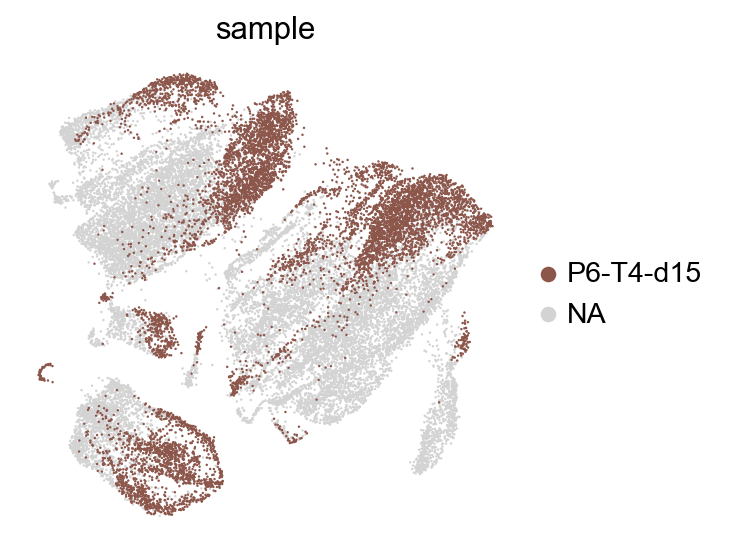

In [44]:
sc.tl.pca(rna_sing, svd_solver='arpack')
sc.pp.neighbors(rna_sing, n_neighbors=15, n_pcs=50)
sc.tl.umap(rna_sing)
sc.pl.umap(rna_sing, color='sample', groups=['P6-T4-d15'])

In [45]:
leiden_map = {'0': 'CD45-', '1': 'CD45+'}
rna_sing.obs['CD45'] = rna_sing.obs['leiden'].map(leiden_map)

In [188]:
rna_sing.obs

sample  n_genes_by_counts  total_counts  \
AAACCAGGTCATGAAG-1-P1-TD-d8    P1-TD-d8                894        1619.0   
AAACGGGCAGTTATGG-1-P1-TD-d8    P1-TD-d8               1025        1729.0   
AAACTGGGTATTCGAC-1-P1-TD-d8    P1-TD-d8                573         796.0   
AAACTGGGTGCACTAT-1-P1-TD-d8    P1-TD-d8               1033        1870.0   
AAACTGGGTTACTCCC-1-P1-TD-d8    P1-TD-d8               1136        1590.0   
...                                 ...                ...           ...   
TTTGTGAGTGAGAAGG-1-P6-T4-d15  P6-T4-d15               3977       11104.0   
TTTGTGAGTTAATTCG-1-P6-T4-d15  P6-T4-d15               2467        4927.0   
TTTGTGAGTTGCGGCT-1-P6-T4-d15  P6-T4-d15               1891        4057.0   
TTTGTGAGTTGGCGAG-1-P6-T4-d15  P6-T4-d15               1428        2375.0   
TTTGTGAGTTTAACCA-1-P6-T4-d15  P6-T4-d15               1737        3659.0   

                              total_counts_mt  pct_counts_mt  n_counts  \
AAACCAGGTCATGAAG-1-P1-TD-d8               5.0       0.308833    1619.0   
AAACGGGCAGTTATGG-1-P1-TD-d8              25.0       1.445922    1729.0   
AAACTGGGTATTCGAC-1-P1-TD-d8               2.0       0.251256     796.0   
AAACTGGGTGCACTAT-1-P1-TD-d8              26.0       1.390374    1870.0   
AAACTGGGTTACTCCC-1-P1-TD-d8               8.0       0.503145    1590.0   
...                                       ...            ...       ...   
TTTGTGAGTGAGAAGG-1-P6-T4-d15             41.0       0.369236   11104.0   
TTTGTGAGTTAATTCG-1-P6-T4-d15              7.0       0.142074    4927.0   
TTTGTGAGTTGCGGCT-1-P6-T4-d15             25.0       0.616219    4057.0   
TTTGTGAGTTGGCGAG-1-P6-T4-d15             11.0       0.463158    2375.0   
TTTGTGAGTTTAACCA-1-P6-T4-d15             22.0       0.601257    3659.0   

                             hashing leiden hashtag   CD45  \
AAACCAGGTCATGAAG-1-P1-TD-d8      1.0      1  Hash 1  CD45+   
AAACGGGCAGTTATGG-1-P1-TD-d8      1.0      0  Hash 1  CD45-   
AAACTGGGTATTCGAC-1-P1-TD-d8      1.0      1  Hash 1  CD45+   
AAACTGGGTGCACTAT-1-P1-TD-d8      1.0      0  Hash 1  CD45-   
AAACTGGGTTACTCCC-1-P1-TD-d8      1.0      0  Hash 1  CD45-   
...                              ...    ...     ...    ...   
TTTGTGAGTGAGAAGG-1-P6-T4-d15     1.0      1  Hash 1  CD45+   
TTTGTGAGTTAATTCG-1-P6-T4-d15     1.0      1  Hash 1  CD45+   
TTTGTGAGTTGCGGCT-1-P6-T4-d15     1.0      1  Hash 1  CD45+   
TTTGTGAGTTGGCGAG-1-P6-T4-d15     1.0      1  Hash 1  CD45+   
TTTGTGAGTTTAACCA-1-P6-T4-d15     1.0      1  Hash 1  CD45+   

                                             nn_80 replicate  
AAACCAGGTCATGAAG-1-P1-TD-d8      Poorly classified        R6  
AAACGGGCAGTTATGG-1-P1-TD-d8   Fibroblast/Adipocyte        R6  
AAACTGGGTATTCGAC-1-P1-TD-d8        Mono/Macrophage        R4  
AAACTGGGTGCACTAT-1-P1-TD-d8           Pericyte/SMC        R3  
AAACTGGGTTACTCCC-1-P1-TD-d8             Tumor cell        R4  
...                                            ...       ...  
TTTGTGAGTGAGAAGG-1-P6-T4-d15       Mono/Macrophage        R1  
TTTGTGAGTTAATTCG-1-P6-T4-d15       Mono/Macrophage        R2  
TTTGTGAGTTGCGGCT-1-P6-T4-d15                mregDC        R4  
TTTGTGAGTTGGCGAG-1-P6-T4-d15                    NK        R2  
TTTGTGAGTTTAACCA-1-P6-T4-d15     Poorly classified        R1  

[25020 rows x 12 columns]

In [51]:
def training_data_select(data, marker, celltypes, cell_types, correct_ind):
    '''

    :param data: input sc data (as anndata)
    :param marker: marker genes (listed in array)
    :param celltypes: matrix indicating which genes correspond to which cell type
    :param cell_types: array indicating which cell types we're searching for
    :param correct_ind: patch to exclude subsets if necessary. default - np.arange(len(celltypes))
    :return labels: cell type labels for ideal examples of each expected cell type
    :return ideal_index: indices of the ideal cells in the total data set (important for reshuffling later on)
    :return training_cells: the expression profiles for these ideal cells
    :return test_cells: the remainder of the data set (those not chosen as ideal examples). provides us with training/
    testing split for the neural network classifier
    '''

    # finding the columns corresponding to each marker gene
    ind = np.zeros(len(marker))
    for i in range(len(ind)):
        ind[i] = np.where(data.var_names == marker[i])[0][0]  # just the index number

    on_off = np.zeros((data.X.shape[0], len(marker)))  # number cells x number marker genes - to store binary expr

    # fitting GMMS for each marker gene in master list
    for j in range(len(marker)):  # for each marker gene for each cell type
        expr = data[:, marker[j]].X.reshape(-1, 1).toarray()   # reshaping to one dimensional array for further analysis
        # print(expr)

        # fit models with 1-5 components
        N = np.arange(1, 6)  # fitting models with 1-5 components (not > 5 for simplicity's sake)
        models = [None for p in range(len(N))]

        # fitting a GMM for each possible component combo
        for k in range(len(N)):
            # models[k] = GaussianMixture(N[k]).fit(expr.toarray())
            models[k] = GaussianMixture(N[k]).fit(expr)

        # compute the AIC and the BIC
        AIC = [m.aic(expr) for m in models]
        BIC = [m.bic(expr) for m in models]  # Lauffenburger paper chooses best GMM by minimizing BIC

        # example for plotting BIC by number of Gaussian components
        # plt.plot(N, BIC, marker='o')
        # plt.xlabel('Number of Gaussian components in fitted GMM')
        # plt.ylabel('Bayesian information criterion (BIC)')
        # plt.show()

        # choosing best model and determining which cells are ON/OFF
        M_best = models[np.argmin(BIC)]  # best GMM by minimizing BIC
        x = np.linspace(-0.5, np.max(expr), len(expr))
        logprob = M_best.score(x.reshape(-1, 1))
        pdf = np.exp(logprob)  # will allow us to understand percentiles of marker gene expression

        # need cluster membership based on chosen model - this will determine ON/OFF states
        gmm_labels = M_best.predict(expr)
        gmm_avg = np.zeros(len(np.unique(gmm_labels)))
        for h in np.unique(gmm_labels):
            gmm_ind = np.where(gmm_labels == h)[0]
            gmm_avg[h] = np.mean(expr[gmm_ind])

        ind_min = np.argmin(expr)  # to identify GMM cluster with smallest mean
        ind_max = np.argmax(expr)  # to identify GMM cluster with largest mean

        if len(np.unique(gmm_labels)) > 2:
            ind_sort = np.argsort(gmm_avg)
            on_marker0 = np.where(gmm_labels != ind_sort[0])[0]
            on_marker1 = np.where(gmm_labels != ind_sort[1])[0]
            on_marker = np.intersect1d(on_marker0, on_marker1)

        else:
            on_marker = np.where(gmm_labels != gmm_labels[ind_min])[0]  # on for cells not in smallest cluster

        # now need to make on/off determinations for each cell in data set
        for i in range(len(on_marker)):  # for indices of the proper cluster membership
            on_off[on_marker[i], j] = 1

    labels = []
    ideal_index = []

    for i in correct_ind:  # for each cell type - intended for easy exclusion of cell subtypes with extra logic
        test_on = np.where(celltypes[i, :] == 1)[0]  # indices of ON marker genes
        # code currently not set up to handle cell types with no ON genes
        for j in range(data.X.shape[0]):  # for each cell in data set
            # want to hold on to ideal cells and their cell type label
            ongenes = on_off[j, test_on]
            all_on = np.sum(ongenes)
            if all_on == len(test_on):
                # now need to include check for OFF
                test_off = np.where(celltypes[i, :] == -1)[0]
                if test_off.shape[0] == 0 or np.sum(on_off[j, test_off]) == 0:
                    # one last check for maybe genes...
                    test_mayb = np.where(celltypes[i, :] == 2)[0]
                    if test_mayb.shape[0] == 0 or np.sum(on_off[j, test_mayb]) >= 2:  # no more than one exception
                        # should probably make this an adaptable/user defined threshold
                        labels.append(i)
                        ideal_index.append(j)

    # removing cells that have been classified as more than one cell type
    doub = np.array([x for x in ideal_index if ideal_index.count(x) > 1])
    g = np.array([])
    for i in range(len(doub)):
        g = np.hstack((g, np.where(ideal_index == doub[i])[0]))  # indices of doubled elements

    ideal_index = np.delete(np.asarray(ideal_index), g.astype('int'))
    labels = np.delete(np.asarray(labels), g.astype('int'))  # converted to numpy array

    training_cells = data.X[ideal_index, :]

    print('Percent of data chosen for training set: ', len(labels)/data.X.shape[0])

    print('Cell type breakdown:')
    for k in range(len(cell_types)):
        perc = np.where(labels == k)[0]
        print('{}: {}'.format(cell_types[k], len(perc)))

    # returning test_cells - remainder of data set
    indices = np.arange(0, data.X.shape[0]).tolist()
    test_ind = np.delete(indices, ideal_index)
    test_cells = data.X[test_ind, :]
    
    
    return labels, ideal_index, training_cells, test_cells


def viz_training_data(tot_data, tot_lab, tot_ideal_ind, types, emb, emb_type, cmap_dict, title, fig_size, leg_adjust):
    '''

    :param tot_data: sc data from which a training set is being selected (anndata)
    :param tot_lab: labels assigned for ideal cell type examples
    :param tot_ideal_ind: indices of ideal examples
    :param types: expected cell types (listed explicitly)
    :param emb: 2D tSNE (or other 2D projection) embedding for total dataset
    :param emb_type: string of 2D embedding type, e.g. 'UMAP'
    :param cmap_dict: colormap of choice (used to label different cell types in visually pleasing manner), dictionary or subscriptable colors
    :param title: title of output figure
    :param fig_size: figure size (int, int)
    :param leg_adjust: adjustment (if necessary) to force legend within window
    :return:
    '''
    # need to establish indices in original data for training and testing data split
    indices = np.arange(0, tot_data.shape[0])
    test_ind = np.delete(indices, tot_ideal_ind)
    all_labels = np.zeros(tot_data.shape[0])

    # establishing a label array defining ideal examples + test data
    for i in range(len(tot_ideal_ind)):
        all_labels[tot_ideal_ind[i]] = tot_lab[i]
    for j in range(len(test_ind)):
        all_labels[test_ind[j]] = -1

    fig, ax = plt.subplots(figsize=fig_size)
    scatter_x = emb[:, 0]
    scatter_y = emb[:, 1]
    for g in np.unique(all_labels):
        i = np.where(all_labels == g)
        if g == -1:
            ax.scatter(scatter_x[i], scatter_y[i], label='Test data', c='xkcd:light grey', alpha=0.75, s=6)
        else:
            ax.scatter(scatter_x[i], scatter_y[i], label=int(g), c=cmap_dict[int(g)], s=6)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})
    plt.title(title)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    plt.xlabel(emb_type + '1')
    plt.ylabel(emb_type + '2')
    plt.subplots_adjust(right=leg_adjust)
    plt.show()


def one_hot_encode(labels):
    '''

    :param labels: cell type labels
    :return: labels_onehot: the same cell type labels, just one hot encoded
    '''
    labels_onehot = np.zeros((len(labels), len(np.unique(labels))))
    for i in range(len(labels)):
        labels_onehot[i, labels[i]] = 1

    return labels_onehot


def cell_type_classifier(ideal_labels, ideal_cells, test_cells, train_ind, learning_rate, training_epochs, batch_size, display_step):
    '''

    :param ideal_labels: cell type labels for ideal examples
    :param ideal_cells: "ideal" examples of each cell type as selected by the above function
    :param test_cells: cells that aren't in training/validation set
    :param train_ind: indices for random selection of ideal cells for training set. Remainder of ideal reserved for validation
    :param learning_rate: controls increments by which neural network can change during training epochs
    :param training_epochs: the number of iterations over which the neural network is allowed to learn
    :param batch_size: size of subsets of training data tested during each training epoch
    :param display_step: how frequently the training epoch cost is displayed
    :return: pred_lab: cell type labels assigned to each cell in the testing data set
    :return: likelihood: probability value associated with the assigned cell type label
    '''

    labels = ideal_labels[train_ind.astype('int'), :]  # 2D one hot encoded labels
    training_cells = ideal_cells[train_ind.astype('int'), :]

    valid_ind = np.delete(np.arange(len(ideal_labels)), train_ind.astype('int'))
    valid_lab = ideal_labels[valid_ind.astype('int'), :]
    valid_cells = ideal_cells[valid_ind.astype('int'), :]
    valid_cells = valid_cells.todense()
    rows = training_cells.shape[1]

    x = tf.placeholder(tf.float32, [None, rows])  # data shape
    y = tf.placeholder(tf.float32, [None, labels.shape[1]])

    # hidden layer variables + transformation
    W_3 = tf.Variable(tf.truncated_normal([rows, 750], stddev=1e-4))
    b_3 = tf.Variable(tf.random_normal([750]))

    hidden = tf.nn.relu(tf.matmul(x, W_3) + b_3)

    # set model weights + biases - can alter width of this hidden layer
    W = tf.Variable(tf.truncated_normal([750, labels.shape[1]], stddev=1e-4))  # originally 130, can be altered
    b = tf.Variable(tf.random_normal([labels.shape[1]]))

    # after hidden layer - nonlinearity could go here
    after = tf.matmul(hidden, W) + b

    # output layer
    pred = tf.nn.softmax(after)  # softmax is final 3rd layer

    # minimize error using cross entropy [could choose alternate entropy eqn here]
    cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(pred + 1e-10), reduction_indices=1))
    # issue with log function if/when pred output hits 0
    # simplest fix here to stay nonzero (can also consider clipping, built in tensorflow functions?)

    # gradient descent optimization
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(training_cells.shape[0] / batch_size)
            # Loop over all batches
            for i in range(total_batch):
                # batch x is random sample from training cells
                # batch y is random sample from training cell LABELS - using batch helps with overfitting
                rand_ind = np.arange(0, training_cells.shape[0])
                rand = np.random.choice(rand_ind, batch_size)
                batch_xs = training_cells[rand, :].todense()  # batch_size random # cells
                #batch_xs = training_cells[rand, :]
                batch_ys = labels[rand, :]

                # Run optimization op (backprop) and cost op (to get loss value)
                _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
                # Compute average loss
                avg_cost += c / total_batch
            # Display logs per epoch step
            if (epoch + 1) % display_step == 0:
                print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

        print("Optimization Finished!")

        # evaluate accuracy of classification with validation set
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))
        accuracy = tf.compat.v1.reduce_mean(tf.cast(correct_prediction, tf.float32))
        

        print("Accuracy:", accuracy.eval({x: valid_cells,
                                          y: valid_lab}))

        # confusion matrix generation for validation set
        x_batch, y_true_batch = valid_cells, valid_lab
        feed_dict = {
            x: x_batch,
            y: y_true_batch,
        }
        true = sess.run(pred, feed_dict=feed_dict)
        lab_not_hot = np.argmax(valid_lab, axis=1)
        prediction = np.argmax(true, axis=1)
        colorm = confusion_matrix(lab_not_hot, prediction)

        # testing data (aka the rest of the data set)
        true1 = sess.run(pred, feed_dict={x: test_cells.todense()})  # need to evaluate the readout here
        likelihood = np.amax(true1, axis=1)
        pred_lab = np.argmax(true1, axis=1)

    return pred_lab, likelihood, colorm, pred


def process_label(tot_prob, tot_lab, total_predicted_lab, tot_ideal_ind, total_data, thresh):
    '''

    :param tot_prob: the probability values associated with the assigned cell type labels, important info when setting
    confidence threshold
    :param tot_lab: cell type labels associated with the ideal (training/valid) data set
    :param total_predicted_lab: cell type labels output by the neural network
    :param tot_ideal_ind: indices of the ideal data set within the total data set, important for reshuffling cell
    type labels to their proper order wrt the original dataset
    :param total_data: for shape of total dataset
    :param thresh: threshold to distinguish "poorly classified" cells
    :return: total_lab_reshuff: the cell type classification labels put back into the proper order
    '''

    # 0. thresholding based on likelihood
    total_predicted_lab_ = np.zeros(len(total_predicted_lab))
    for k in range(len(tot_prob)):
        if tot_prob[k] < thresh:
            total_predicted_lab_[k] = -1
        else:
            total_predicted_lab_[k] = total_predicted_lab[k]

    # 1. reordering
    indices = np.arange(0, total_data.X.shape[0])
    test_ind = np.delete(indices, tot_ideal_ind.astype('int'))
    total_lab_reshuff = np.zeros(total_data.X.shape[0])
    tot_prob_reshuff = np.zeros(total_data.X.shape[0])

    for i in range(len(tot_ideal_ind)):
        total_lab_reshuff[tot_ideal_ind[i]] = tot_lab[i]
        tot_prob_reshuff[tot_ideal_ind[i]] = 1.01  # encoding "ideal" cells in probability info
    for j in range(len(test_ind)):
        total_lab_reshuff[test_ind[j]] = total_predicted_lab_[j]
        tot_prob_reshuff[test_ind[j]] = tot_prob[j]

    return total_lab_reshuff, tot_prob_reshuff

In [204]:
marker = ['Cd3d','Cd3e','Cd3g','Cd4','Foxp3','Il2ra','Cd8a',
            'Ncr1','Klri2','Csf1r','Itgam','Cd68','Ccr7',
            'Clec9a','Naaa','Xcr1','Cd79a','Pax5','Cd19','Clec10a','Cd209a','Tcf4',
            'Siglech','Plac8','Ighm','Lcn2','Cxcr2','Hdc',
            'Cma1','Cpa3','Tpsb2','Tpsab1','Ms4a2','Mcpt8','Col1a1','Dcn',
            'Vwf','Tek','Pecam1','Perp','Apoe','Krt14','Des','Rgs5','Acta2',
            'Cxcl14','Ucp2','Cd74','Sox9','Sox10','Lgals7','Col6a3',
            'Aqp1','Cacnb3','Fscn1','Ptprc'
          ]

cell_types = ['CD4 T cell','CD8 T cell','Treg','NK','B cell','cDC1','cDC2','pDC',
              'Mono/Macrophage','Neutrophil','Mast cell','Basophil',
              'Fibroblast/Adipocyte','Endothelial','Keratinocyte',
              'Pericyte/SMC','Fibro-adipogenic progenitor','Melanocyte','Tumor cell','mregDC']

In [115]:
#Round1 classification
#celltypes = np.zeros((len(cell_types), len(marker)))
#celltypes[0, :7] = [1, 1, 1, 1, -1, -1, -1]  # CD4+
#celltypes[1, :7] = [1, 1, 1, -1, -1, -1, 1]  # CD8+
#celltypes[2, :7] = [1, 1, 1, 1, 1, 0, -1]  # Treg
#celltypes[3, :3] = [-1, -1, -1]  # NK
#celltypes[3, 7:9] = [1, 1] #NK
#celltypes[:4, 9:12] = -1*np.ones((4, 3))
#celltypes[4]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # Bcell
#celltypes[5]=[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # cDC1
#celltypes[6]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # cDC2
#celltypes[7]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # pDC
#celltypes[8]=[-1,-1,-1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Macrophage
#celltypes[9]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0] #Neutrophil
#celltypes[10]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0] #Mast cell
#celltypes[11]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0] #Basophil
#celltypes[12]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0] #FB/adipocyte
#celltypes[13]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0] #Endothelial
#celltypes[14]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0] #Keratinocyte
#celltypes[15]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0] #Pericyte
#celltypes[16]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0] #FB/adipogenic progenitor
#celltypes[17]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0] #Melanocyte
#celltypes[18]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0] #Tumor cell
#celltypes[19]=[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1] #mregDC

In [213]:
#Round2 classification (modified round1 marker genes to include more markers for most cell type)
celltypes = np.zeros((len(cell_types), len(marker)))
celltypes[0, :7] = [1, 1, 1, 1, -1, -1, -1]  # CD4+
celltypes[1, :7] = [1, 1, 1, -1, -1, -1, 1]  # CD8+
celltypes[2, :7] = [1, 1, 1, 1, 1, 0, -1]  # Treg
celltypes[3, :3] = [-1, -1, -1]  # NK
celltypes[3, 7:9] = [1, 1] #NK
celltypes[:4, 9:12] = -1*np.ones((4, 3))
celltypes[4,16:19] = [1,1,1] # B cell
celltypes[5,13:16] = [1,1,1] #cDC1 
celltypes[6,19:21] = [1,1] #cDC2
celltypes[7,21:25] = [1,1,1,1] #pDC
celltypes[8, :3] = [-1,-1,-1] #Monocyte/macrophage
celltypes[8, 9:12] = [1,1,1] #Monocyte/macrophage
celltypes[9,25:28] = [1,1,1] #neutrophil
celltypes[10,28:32] = [1,1,1,1] #mast cell
celltypes[11,32:34] = [1,1] #basophil
celltypes[12,34:36] = [1,1] #fibroblast/adipocyte
celltypes[13,36:39] = [1,1,1] #endothelial
celltypes[14,39:42] = [1,1,1] #keratinocyte
celltypes[15,42:45] = [1,1,1] #pericyte
celltypes[16,45:48] = [1,1,1] #fibro-adipogenic progenitor
celltypes[17,48:50] = [1,1] #melanocyte
celltypes[18,50:53] = [1,1,1] #tumor cell
celltypes[19,53:56] = [1,1,1] #mregDC
celltypes[19,12:13] = [1] #mregDC
celltypes[:12,55:56] = [1] #All immune cells marked Cd45+

In [214]:
tot_lab, tot_ideal_ind, tot_traindata, tot_testdata = training_data_select(rna_sing, marker, celltypes, cell_types,np.arange(len(cell_types)))

Percent of data chosen for training set:  0.35891286970423664
Cell type breakdown:
CD4 T cell: 69
CD8 T cell: 202
Treg: 82
NK: 96
B cell: 44
cDC1: 20
cDC2: 30
pDC: 26
Mono/Macrophage: 1358
Neutrophil: 216
Mast cell: 47
Basophil: 10
Fibroblast/Adipocyte: 1614
Endothelial: 138
Keratinocyte: 58
Pericyte/SMC: 60
Fibro-adipogenic progenitor: 204
Melanocyte: 0
Tumor cell: 4398
mregDC: 308


In [215]:
sasha_trubet = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

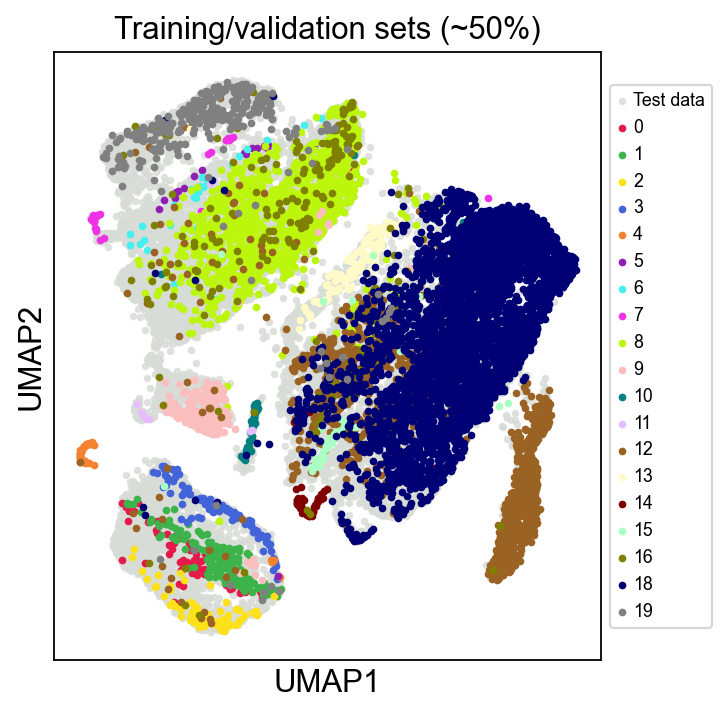

In [216]:
viz_training_data(rna_sing, tot_lab, tot_ideal_ind, cell_types, rna_sing.obsm['X_umap'], 'UMAP', sasha_trubet,
                  'Training/validation sets (~50%)', (6, 5), 0.75)

In [217]:
learning_rate = 0.025  # altering learning rate to change how much neural net can adjust during each training epoch
training_epochs = 1000
batch_size = 100
display_step = 5

In [220]:
tot_lab_onehot = one_hot_encode(tot_lab)
all_train_ind = np.array([])
ideal_ = np.argmax(tot_lab_onehot, axis=1)
train_split = 0.5
for k in np.unique(ideal_):
    all_ind = np.where(ideal_ == k)[0]  # randomly select half for training, other half goes to validation
    train_ind = np.random.choice(all_ind, round(train_split*len(all_ind)), replace=False)
    all_train_ind = np.concatenate((all_train_ind, train_ind))

IndexError: index 19 is out of bounds for axis 1 with size 19

In [243]:
labels_onehot = np.zeros((len(tot_lab), len(np.unique(tot_lab))))  
labels_onehot.shape
#for i in range(len(tot_lab)):
#        labels_onehot[i, tot_lab[i]] = 1

#return labels_onehot[0]

(8980, 19)

In [219]:
total_predicted_lab, tot_prob, colorm, pred = cell_type_classifier(tot_lab_onehot, tot_traindata,
                                                                   tot_testdata,
                                                                   all_train_ind,
                                                                   learning_rate, training_epochs, batch_size,
                                                                   display_step)

IndexError: index (10655) out of range

In [64]:
total_lab, total_prob = process_label(tot_prob, tot_lab, total_predicted_lab, tot_ideal_ind, rna_sing, 0.8)

In [65]:
cluster2annotation = { 0: 'CD4 T cell', 1: 'CD8 T cell', 2:'Treg',3:'NK',4:'B cell',5: 'cDC1',6:'cDC2',7:'pDC',
                8:'Mono/Macrophage',9: 'Neutrophil',
                10:'Mast cell',11: 'Basophil', 12:  'Fibroblast/Adipocyte',13: 'Endothelial',
                14: 'Keratinocyte',15: 'Pericyte/SMC',16: 'Fibro-adipogenic progenitor', 17:'Melanocyte',
              18: 'Tumor cell' , 19: 'mregDC', -1: 'Poorly classified' }


rna_sing.obs['nn_80'] = pd.Series(total_lab.astype('int')).map(cluster2annotation).values

In [67]:
rna_sing.obs['nn_80']

AAACCAGGTCATGAAG-1-P1-TD-d8        Poorly classified
AAACGGGCAGTTATGG-1-P1-TD-d8     Fibroblast/Adipocyte
AAACTGGGTATTCGAC-1-P1-TD-d8          Mono/Macrophage
AAACTGGGTGCACTAT-1-P1-TD-d8             Pericyte/SMC
AAACTGGGTTACTCCC-1-P1-TD-d8               Tumor cell
                                        ...         
TTTGTGAGTGAGAAGG-1-P6-T4-d15         Mono/Macrophage
TTTGTGAGTTAATTCG-1-P6-T4-d15         Mono/Macrophage
TTTGTGAGTTGCGGCT-1-P6-T4-d15                  mregDC
TTTGTGAGTTGGCGAG-1-P6-T4-d15                      NK
TTTGTGAGTTTAACCA-1-P6-T4-d15       Poorly classified
Name: nn_80, Length: 25020, dtype: object

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


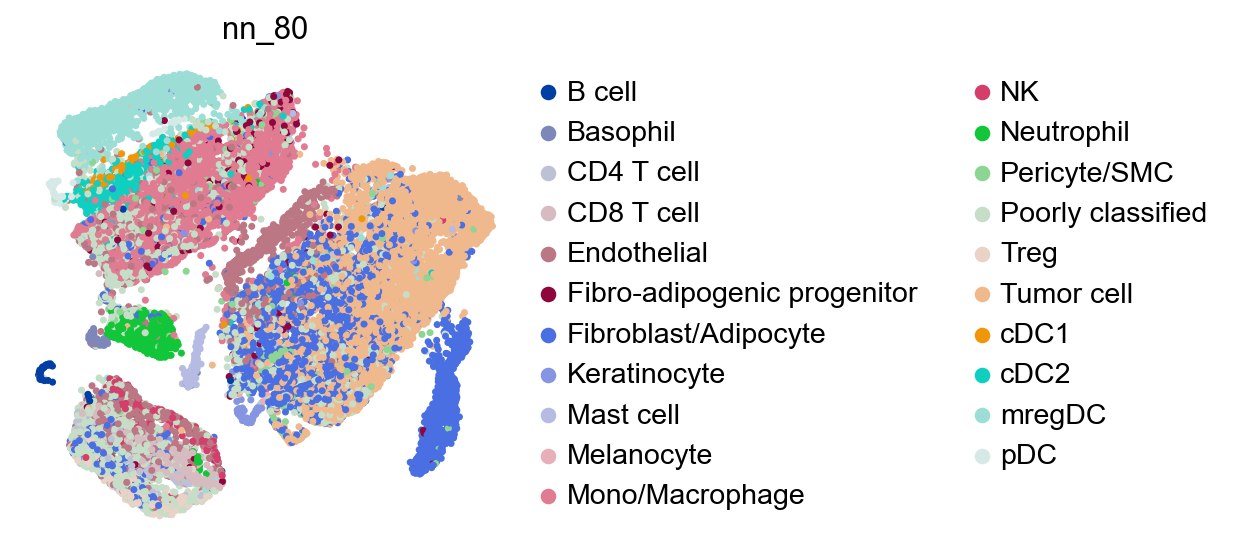

In [69]:
sc.pl.umap(rna_sing, color = 'nn_80', s = 40)

In [70]:
rna_sing.write_h5ad(filename='rna_slot_25k_singlets_annotated.h5ad')

In [100]:
def encode_replicates(adata, rep_dict):
    rep = [None] * adata.shape[0]
    for z in np.arange(adata.shape[0]):
        if np.sum(adata.obsm['hash_onoff'][z]) > 0:
            z_arg = np.argmax(adata.obsm['hash_onoff'][z])
            rep[z] = 'R{}'.format(z_arg+1)
        else:
            rep[z] = 'R0'
    return rep

In [101]:
rna_sing.obs['replicate'] = encode_replicates(rna_sing, None)





In [111]:
sc.tl.rank_genes_groups(rna_sing, 'nn_80', method='t-test')



/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/tools/_rank_genes_grou

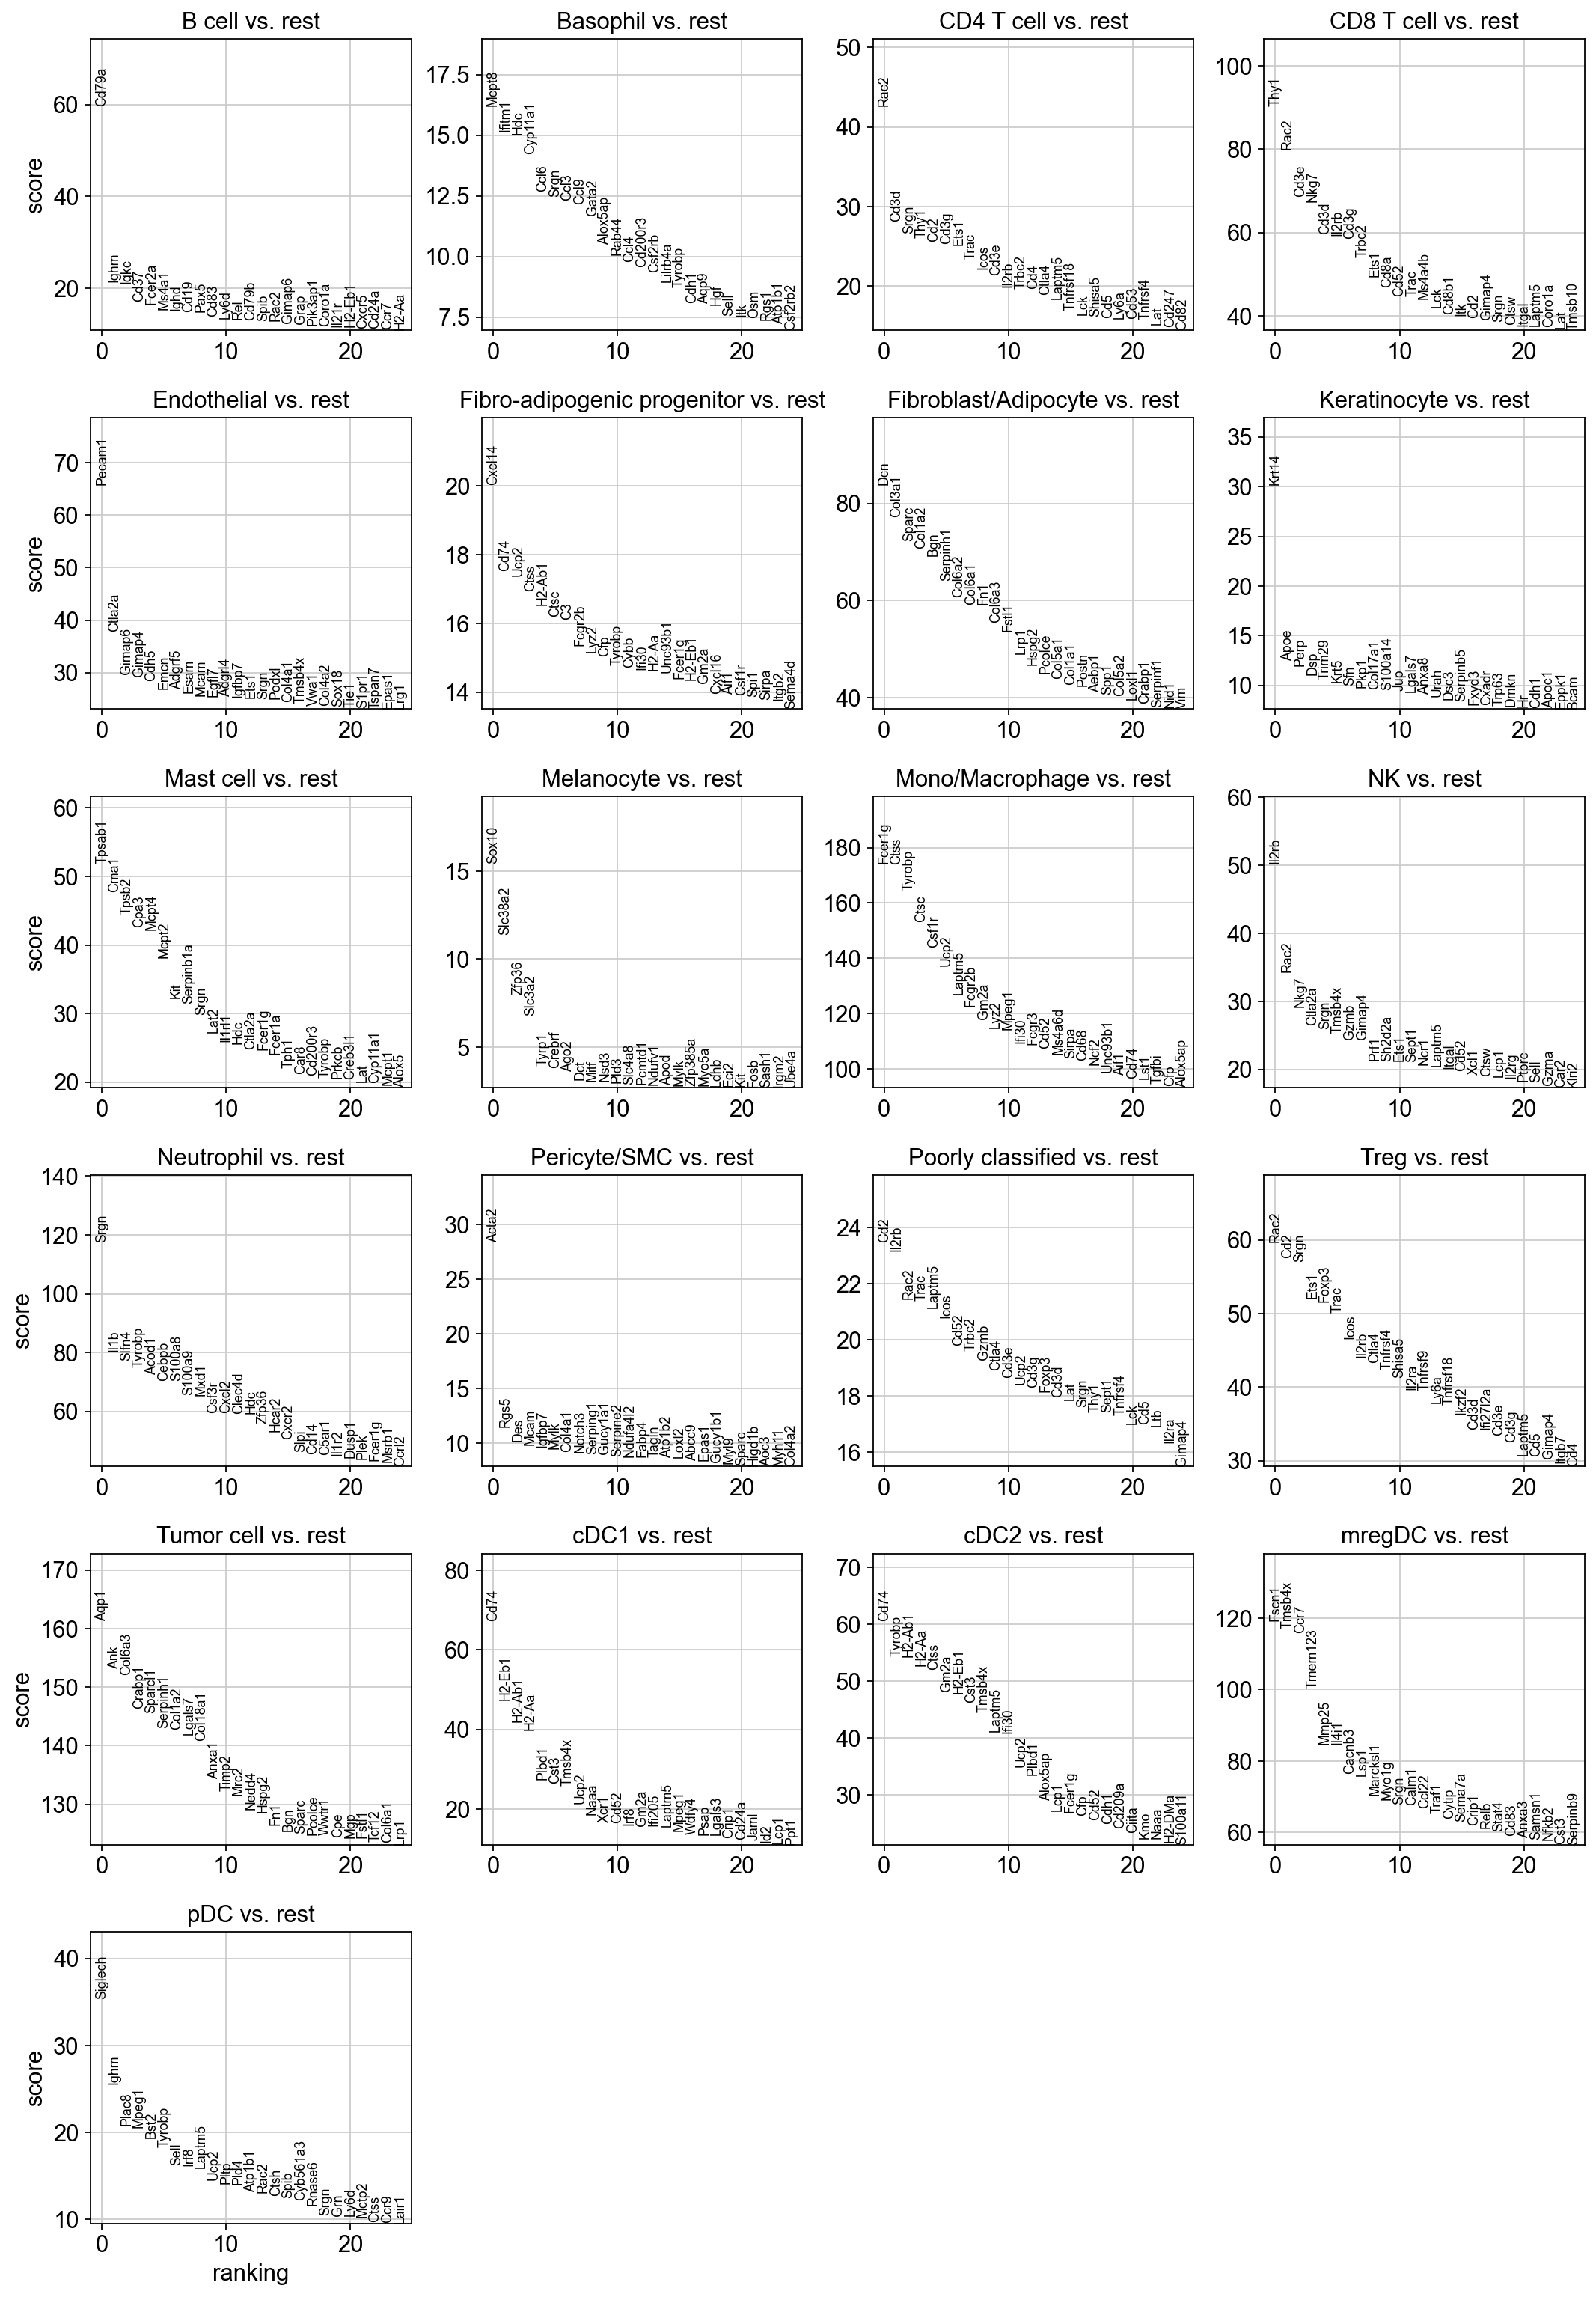

In [113]:
sc.pl.rank_genes_groups(rna_sing, n_genes=25, sharey=False)



In [112]:
rna_sing.obs

sample  n_genes_by_counts  total_counts  \
AAACCAGGTCATGAAG-1-P1-TD-d8    P1-TD-d8                894        1619.0   
AAACGGGCAGTTATGG-1-P1-TD-d8    P1-TD-d8               1025        1729.0   
AAACTGGGTATTCGAC-1-P1-TD-d8    P1-TD-d8                573         796.0   
AAACTGGGTGCACTAT-1-P1-TD-d8    P1-TD-d8               1033        1870.0   
AAACTGGGTTACTCCC-1-P1-TD-d8    P1-TD-d8               1136        1590.0   
...                                 ...                ...           ...   
TTTGTGAGTGAGAAGG-1-P6-T4-d15  P6-T4-d15               3977       11104.0   
TTTGTGAGTTAATTCG-1-P6-T4-d15  P6-T4-d15               2467        4927.0   
TTTGTGAGTTGCGGCT-1-P6-T4-d15  P6-T4-d15               1891        4057.0   
TTTGTGAGTTGGCGAG-1-P6-T4-d15  P6-T4-d15               1428        2375.0   
TTTGTGAGTTTAACCA-1-P6-T4-d15  P6-T4-d15               1737        3659.0   

                              total_counts_mt  pct_counts_mt  n_counts  \
AAACCAGGTCATGAAG-1-P1-TD-d8               5.0       0.308833    1619.0   
AAACGGGCAGTTATGG-1-P1-TD-d8              25.0       1.445922    1729.0   
AAACTGGGTATTCGAC-1-P1-TD-d8               2.0       0.251256     796.0   
AAACTGGGTGCACTAT-1-P1-TD-d8              26.0       1.390374    1870.0   
AAACTGGGTTACTCCC-1-P1-TD-d8               8.0       0.503145    1590.0   
...                                       ...            ...       ...   
TTTGTGAGTGAGAAGG-1-P6-T4-d15             41.0       0.369236   11104.0   
TTTGTGAGTTAATTCG-1-P6-T4-d15              7.0       0.142074    4927.0   
TTTGTGAGTTGCGGCT-1-P6-T4-d15             25.0       0.616219    4057.0   
TTTGTGAGTTGGCGAG-1-P6-T4-d15             11.0       0.463158    2375.0   
TTTGTGAGTTTAACCA-1-P6-T4-d15             22.0       0.601257    3659.0   

                             hashing leiden hashtag   CD45  \
AAACCAGGTCATGAAG-1-P1-TD-d8      1.0      1  Hash 1  CD45+   
AAACGGGCAGTTATGG-1-P1-TD-d8      1.0      0  Hash 1  CD45-   
AAACTGGGTATTCGAC-1-P1-TD-d8      1.0      1  Hash 1  CD45+   
AAACTGGGTGCACTAT-1-P1-TD-d8      1.0      0  Hash 1  CD45-   
AAACTGGGTTACTCCC-1-P1-TD-d8      1.0      0  Hash 1  CD45-   
...                              ...    ...     ...    ...   
TTTGTGAGTGAGAAGG-1-P6-T4-d15     1.0      1  Hash 1  CD45+   
TTTGTGAGTTAATTCG-1-P6-T4-d15     1.0      1  Hash 1  CD45+   
TTTGTGAGTTGCGGCT-1-P6-T4-d15     1.0      1  Hash 1  CD45+   
TTTGTGAGTTGGCGAG-1-P6-T4-d15     1.0      1  Hash 1  CD45+   
TTTGTGAGTTTAACCA-1-P6-T4-d15     1.0      1  Hash 1  CD45+   

                                             nn_80 replicate  
AAACCAGGTCATGAAG-1-P1-TD-d8      Poorly classified        R6  
AAACGGGCAGTTATGG-1-P1-TD-d8   Fibroblast/Adipocyte        R6  
AAACTGGGTATTCGAC-1-P1-TD-d8        Mono/Macrophage        R4  
AAACTGGGTGCACTAT-1-P1-TD-d8           Pericyte/SMC        R3  
AAACTGGGTTACTCCC-1-P1-TD-d8             Tumor cell        R4  
...                                            ...       ...  
TTTGTGAGTGAGAAGG-1-P6-T4-d15       Mono/Macrophage        R1  
TTTGTGAGTTAATTCG-1-P6-T4-d15       Mono/Macrophage        R2  
TTTGTGAGTTGCGGCT-1-P6-T4-d15                mregDC        R4  
TTTGTGAGTTGGCGAG-1-P6-T4-d15                    NK        R2  
TTTGTGAGTTTAACCA-1-P6-T4-d15     Poorly classified        R1  

[25020 rows x 12 columns]

In [80]:
np.arange(rna_sing.shape[0])

array([    0,     1,     2, ..., 25017, 25018, 25019])

In [92]:
np.argmax(rna_sing.obsm['hash_onoff'][0])

5

In [96]:
rna_sing.obs['sample']

AAACCAGGTCATGAAG-1-P1-TD-d8      P1-TD-d8
AAACGGGCAGTTATGG-1-P1-TD-d8      P1-TD-d8
AAACTGGGTATTCGAC-1-P1-TD-d8      P1-TD-d8
AAACTGGGTGCACTAT-1-P1-TD-d8      P1-TD-d8
AAACTGGGTTACTCCC-1-P1-TD-d8      P1-TD-d8
                                  ...    
TTTGTGAGTGAGAAGG-1-P6-T4-d15    P6-T4-d15
TTTGTGAGTTAATTCG-1-P6-T4-d15    P6-T4-d15
TTTGTGAGTTGCGGCT-1-P6-T4-d15    P6-T4-d15
TTTGTGAGTTGGCGAG-1-P6-T4-d15    P6-T4-d15
TTTGTGAGTTTAACCA-1-P6-T4-d15    P6-T4-d15
Name: sample, Length: 25020, dtype: category
Categories (6, object): ['P1-TD-d8', 'P2-T1-d8', 'P3-TD-d12', 'P4-T2-d12', 'P5-T0-d15', 'P6-T4-d15']